# ML Resit

Author : Etienne Chatreaux

In [1]:
# Libs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap



import preprocessing as p
import pipelines as my_pipes

from sklearn.model_selection import train_test_split


dataset_path = r"data\dataset_rattrappage_june_2025.csv"

In [2]:
# Load data

dataset = pd.read_csv(dataset_path, low_memory=True)
print(dataset.shape)

(537667, 17)


# EDA

In [3]:
for col in dataset.columns:
    print(col, dataset[col].nunique(), dataset[col].unique())
    
# dataset.describe()

CODE_GENDER 2 ['F' 'M']
FLAG_OWN_CAR 2 ['Y' 'N']
FLAG_OWN_REALTY 2 ['N' 'Y']
CNT_CHILDREN 3 ['2+ children' 'No children' '1 children']
AMT_INCOME_TOTAL 195 [ 270000.    81000.   112500.   139500.   144000.   180000.   405000.
  135000.    99000.   103500.   225000.   171000.   202500.    67500.
  121500.   560250.    74250.    90000.   324000.   391500.   292500.
  229500.   157500.    94500.   148500.   450000.    45000.   382500.
  126000.   315000.   306000.   247500.   675000.    36000.   562500.
  337500.   360000.   211500.   119250.   216000.   122400.   220500.
  193500.   427500.    63000.    76500.   472500.   495000.    95850.
   54000.   459000.   540000.   265500.   146250.   108000.   283500.
  310500.   130500.   252000.   234000.   198000.   166500.   256500.
  153000.   207000.   607500.   468000.    72000.   279000.   238500.
   85500.   173250.    62653.5  445500.   117000.   184500.   261000.
  189000.   162000.   326250.   387000.   190399.5   40500.    60376.5
  5

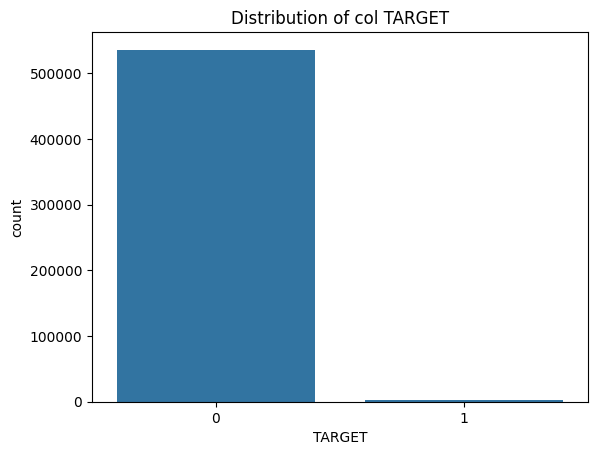

TARGET
0    99.63509
1     0.36491
Name: proportion, dtype: float64


In [4]:
target_col = 'TARGET'

sns.countplot(data=dataset, x=target_col)
plt.title(f'Distribution of col {target_col}')
plt.show()

print(dataset[target_col].value_counts(normalize=True) * 100)

In [5]:
# Very important : visualize the data target = 1

display(dataset[dataset['TARGET'] == 1].describe())
display(dataset[dataset['TARGET'] == 1])

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,BEGIN_MONTHS,TARGET
count,1962.000000,1962.000000,1962.000000,1962.0,1962.000000,1962.000000,1962.000000,1962.000000,1962.0
mean,202085.788991,-15315.856269,-2001.337920,1.0,0.313965,0.364424,0.091743,-19.687054,1.0
std,115214.171791,3451.543036,1999.323064,0.0,0.464221,0.481391,0.288737,14.033904,0.0
min,36000.000000,-22800.000000,-10454.000000,1.0,0.000000,0.000000,0.000000,-56.000000,1.0
25%,112500.000000,-18661.000000,-2878.750000,1.0,0.000000,0.000000,0.000000,-31.000000,1.0
50%,162000.000000,-15645.000000,-1216.000000,1.0,0.000000,0.000000,0.000000,-17.000000,1.0
75%,238500.000000,-12370.750000,-614.750000,1.0,1.000000,1.000000,0.000000,-8.000000,1.0
max,900000.000000,-8168.000000,-65.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.0


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,TARGET
102,F,N,Y,No children,90000.0,Secondary / secondary special,Civil marriage,House / apartment,-16569,-517,1,0,0,0,Laborers,-38,1
325,M,Y,Y,No children,112500.0,Secondary / secondary special,Married,House / apartment,-17300,-1235,1,0,0,0,Drivers,-44,1
380,F,Y,Y,1 children,265500.0,Higher education,Married,With parents,-10998,-2514,1,0,0,0,Accountants,-9,1
529,F,N,Y,No children,202500.0,Secondary / secondary special,Married,House / apartment,-14523,-3420,1,0,0,0,Core staff,-16,1
764,F,Y,Y,No children,90000.0,Secondary / secondary special,Married,House / apartment,-18950,-1002,1,1,1,0,Cooking staff,-35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536562,F,N,Y,No children,180000.0,Lower secondary,Widow,House / apartment,-16803,-2227,1,1,1,0,Cleaning staff,-35,1
537065,M,Y,N,No children,135000.0,Secondary / secondary special,Married,House / apartment,-14209,-97,1,0,0,0,Security staff,-34,1
537289,M,N,Y,No children,225000.0,Secondary / secondary special,Civil marriage,House / apartment,-12451,-1646,1,0,0,0,Sales staff,-2,1
537445,M,Y,Y,No children,225000.0,Secondary / secondary special,Married,House / apartment,-17915,-3366,1,0,0,0,Drivers,-30,1


# Cleaning

In [6]:
# There is a column with only 1 value so we remove it

if "FLAG_MOBIL" in dataset.columns:
    cols_to_remove = ["FLAG_MOBIL"]
    dataset = dataset.drop(columns=cols_to_remove)
    print("Column removed!")

Column removed!


# Feature Engineering

In [7]:
mapping = {
    'CODE_GENDER': {'M': 1, 'F': 0},
    'FLAG_OWN_CAR': {'Y': 1, 'N': 0}, 
    'FLAG_OWN_REALTY': {'Y': 1, 'N': 0},
    'CNT_CHILDREN': {'No children': 0, '1 children': 1, '2+ children': 2},
    'NAME_EDUCATION_TYPE': {'Lower secondary': 0, 'Secondary / secondary special': 1, 'Incomplete higher': 2, 'Higher education': 3, 'Academic degree': 4}
}

# Apply mapping to categorical columns
for col, map_dict in mapping.items():
    if col in dataset.columns:
        dataset[col] = dataset[col].map(map_dict)
        print(f"Mapped column: {col}")

Mapped column: CODE_GENDER
Mapped column: FLAG_OWN_CAR
Mapped column: FLAG_OWN_REALTY
Mapped column: CNT_CHILDREN
Mapped column: NAME_EDUCATION_TYPE


In [8]:
# Temporal changes

dataset['AGE'] = (-dataset['DAYS_BIRTH'] / 365).astype(int) 
dataset['YEARS_EMPLOYED'] = (-dataset['DAYS_EMPLOYED'] / 365).clip(lower=0)
dataset['CLIENT_DURATION_YEARS'] = (-dataset['BEGIN_MONTHS']) / 12
dataset['EMPLOYMENT_CLIENT_RATIO'] = dataset['YEARS_EMPLOYED'] / (dataset['CLIENT_DURATION_YEARS'] + 0.01)

In [9]:
# Financial changes

dataset['INCOME_PER_CHILD'] = dataset['AMT_INCOME_TOTAL'] / (dataset['CNT_CHILDREN'] + 1)
dataset['INCOME_BY_AGE'] = dataset['AMT_INCOME_TOTAL'] / (dataset['AGE'] + 1)
dataset['INCOME_BY_EMPLOYMENT'] = dataset['AMT_INCOME_TOTAL'] / (dataset['YEARS_EMPLOYED'] + 1)
dataset['INCOME_BY_CLIENT_DURATION'] = dataset['AMT_INCOME_TOTAL'] / (dataset['CLIENT_DURATION_YEARS'] + 0.01)
dataset['LOG_INCOME'] = np.log(dataset['AMT_INCOME_TOTAL'])

In [10]:
dataset['HAS_CONTACT_INFO'] = dataset[['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']].sum(axis=1)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'JOB', 'BEGIN_MONTHS', 'TARGET', 'AGE',
       'YEARS_EMPLOYED', 'CLIENT_DURATION_YEARS', 'EMPLOYMENT_CLIENT_RATIO',
       'INCOME_PER_CHILD', 'INCOME_BY_AGE', 'INCOME_BY_EMPLOYMENT',
       'INCOME_BY_CLIENT_DURATION', 'LOG_INCOME', 'HAS_CONTACT_INFO'],
      dtype='object')
Numerical cols:


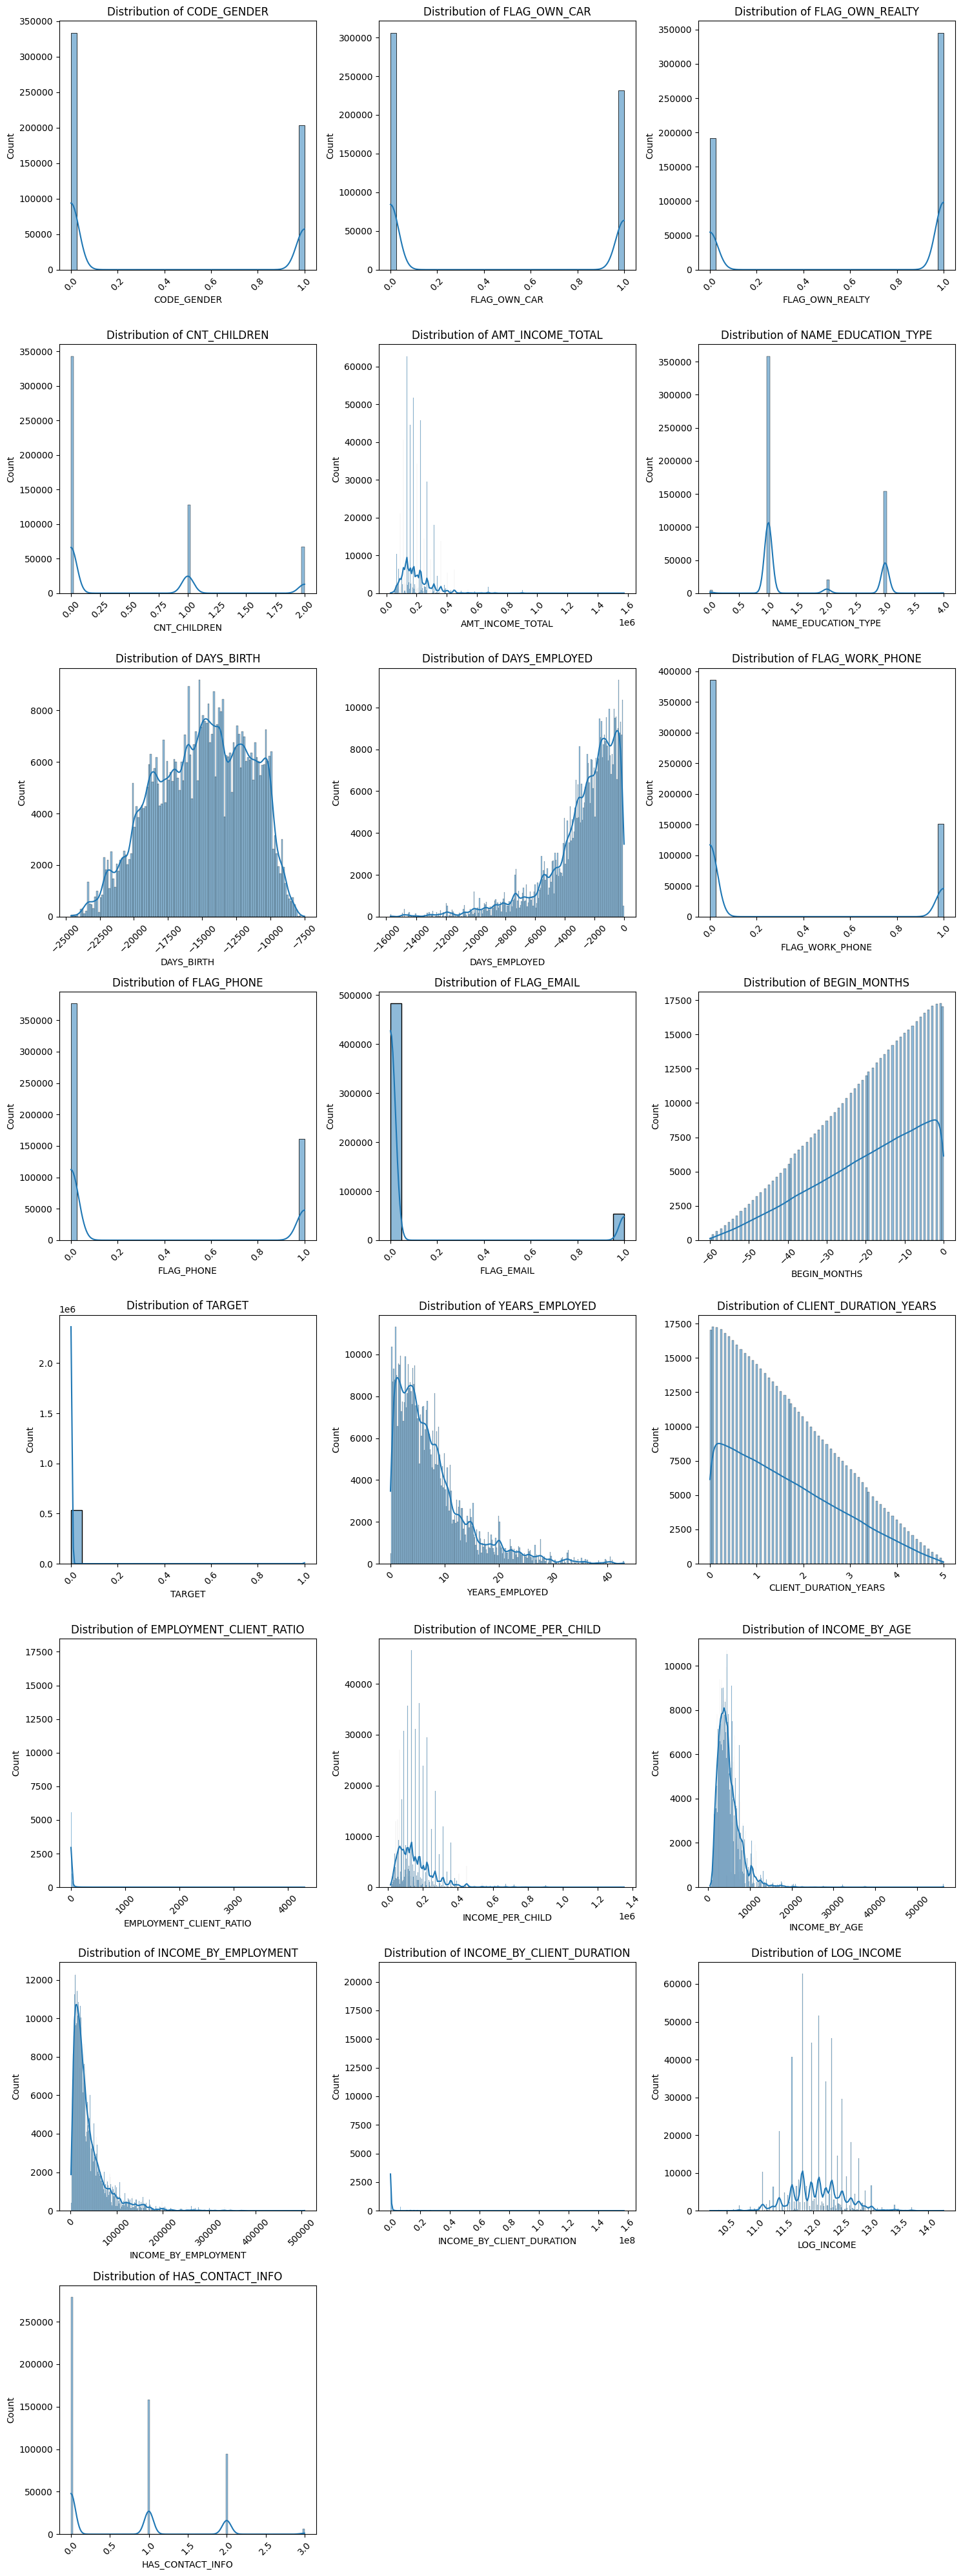

Categorical cols:


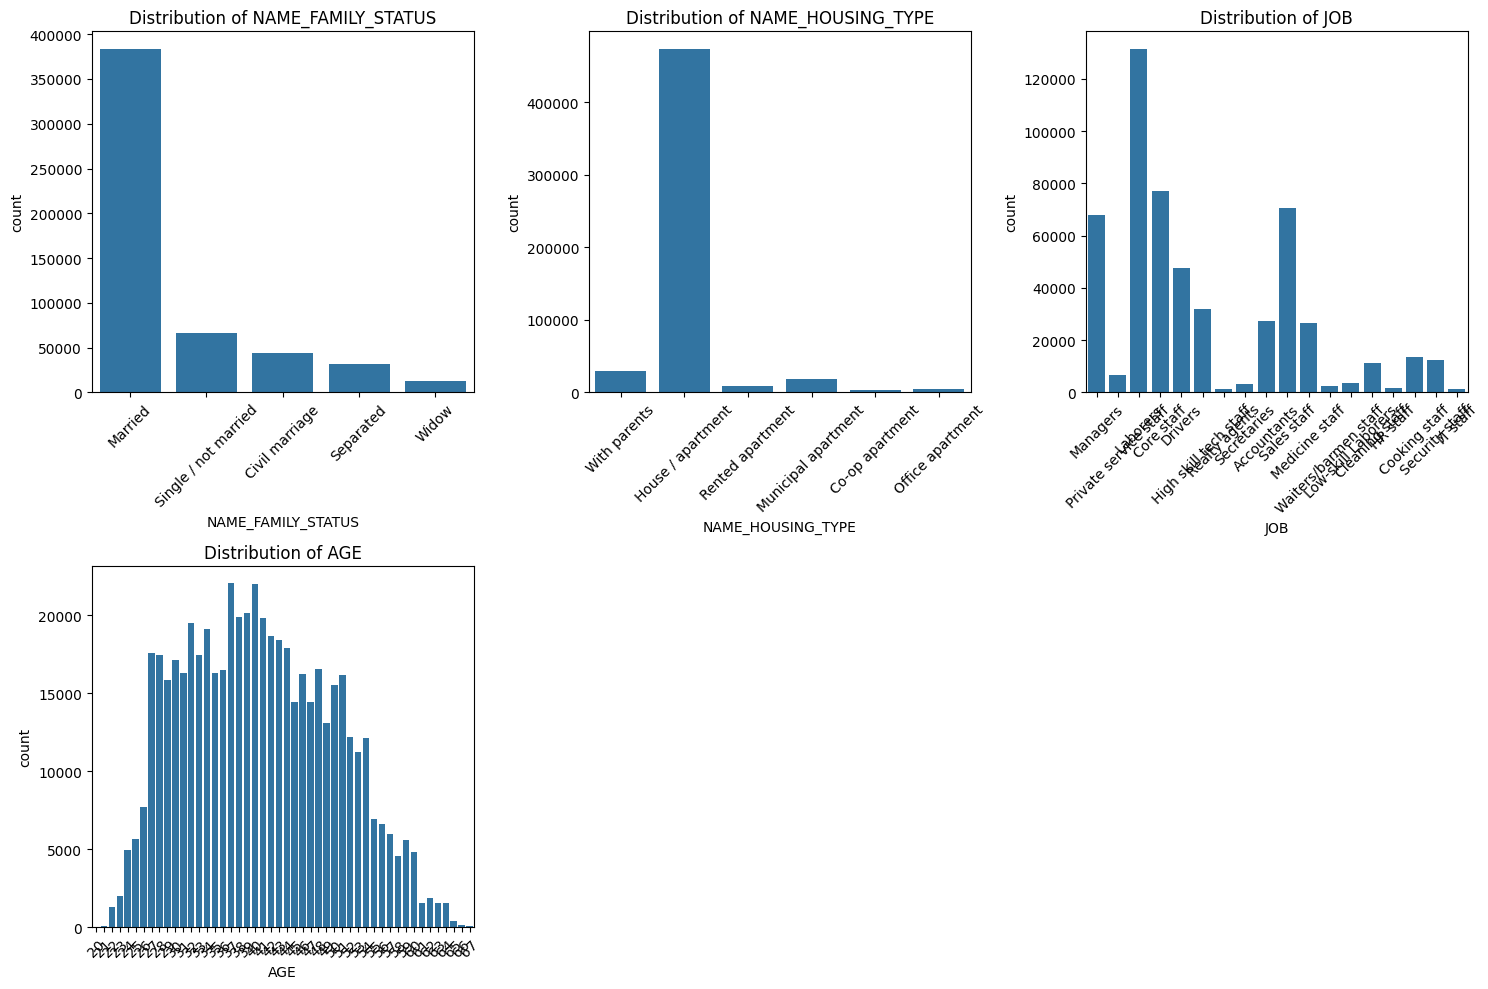

In [11]:
print(dataset.columns)

p.plot_distributions(dataset)

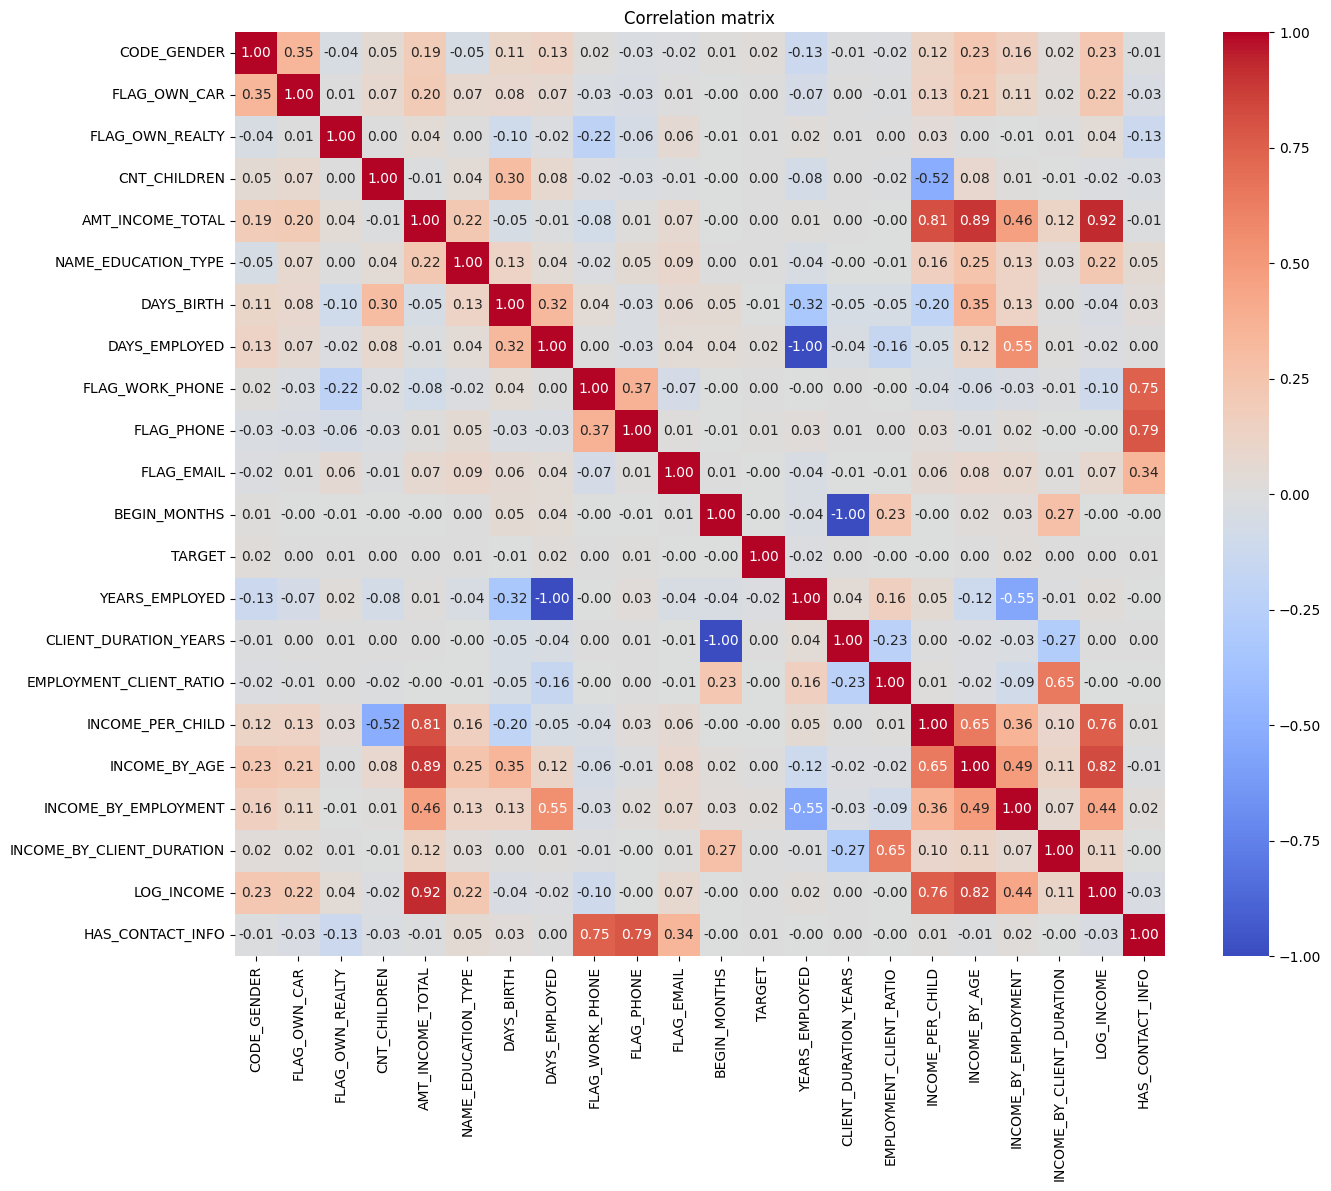

In [12]:
# It's possible to visualize the corr matrix or just the correlations with TARGET, you need to change only_target to False/True
corr_array = p.plot_correlation_matrix(dataset, only_target=False)

I have created some new features very correlated but it's not a big deal because RandomForest is not sensitive to multicollinearity. Same for NN but it can slow the convergence. We'll see later if we drop some columns!

In [13]:
cols_to_drop = ["AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED", "BEGIN_MONTHS"]

for col in cols_to_drop:
    if col in dataset.columns:
        dataset = dataset.drop(columns=[col])
        print(f"Column {col} removed!")

Column AMT_INCOME_TOTAL removed!
Column DAYS_BIRTH removed!
Column DAYS_EMPLOYED removed!
Column BEGIN_MONTHS removed!


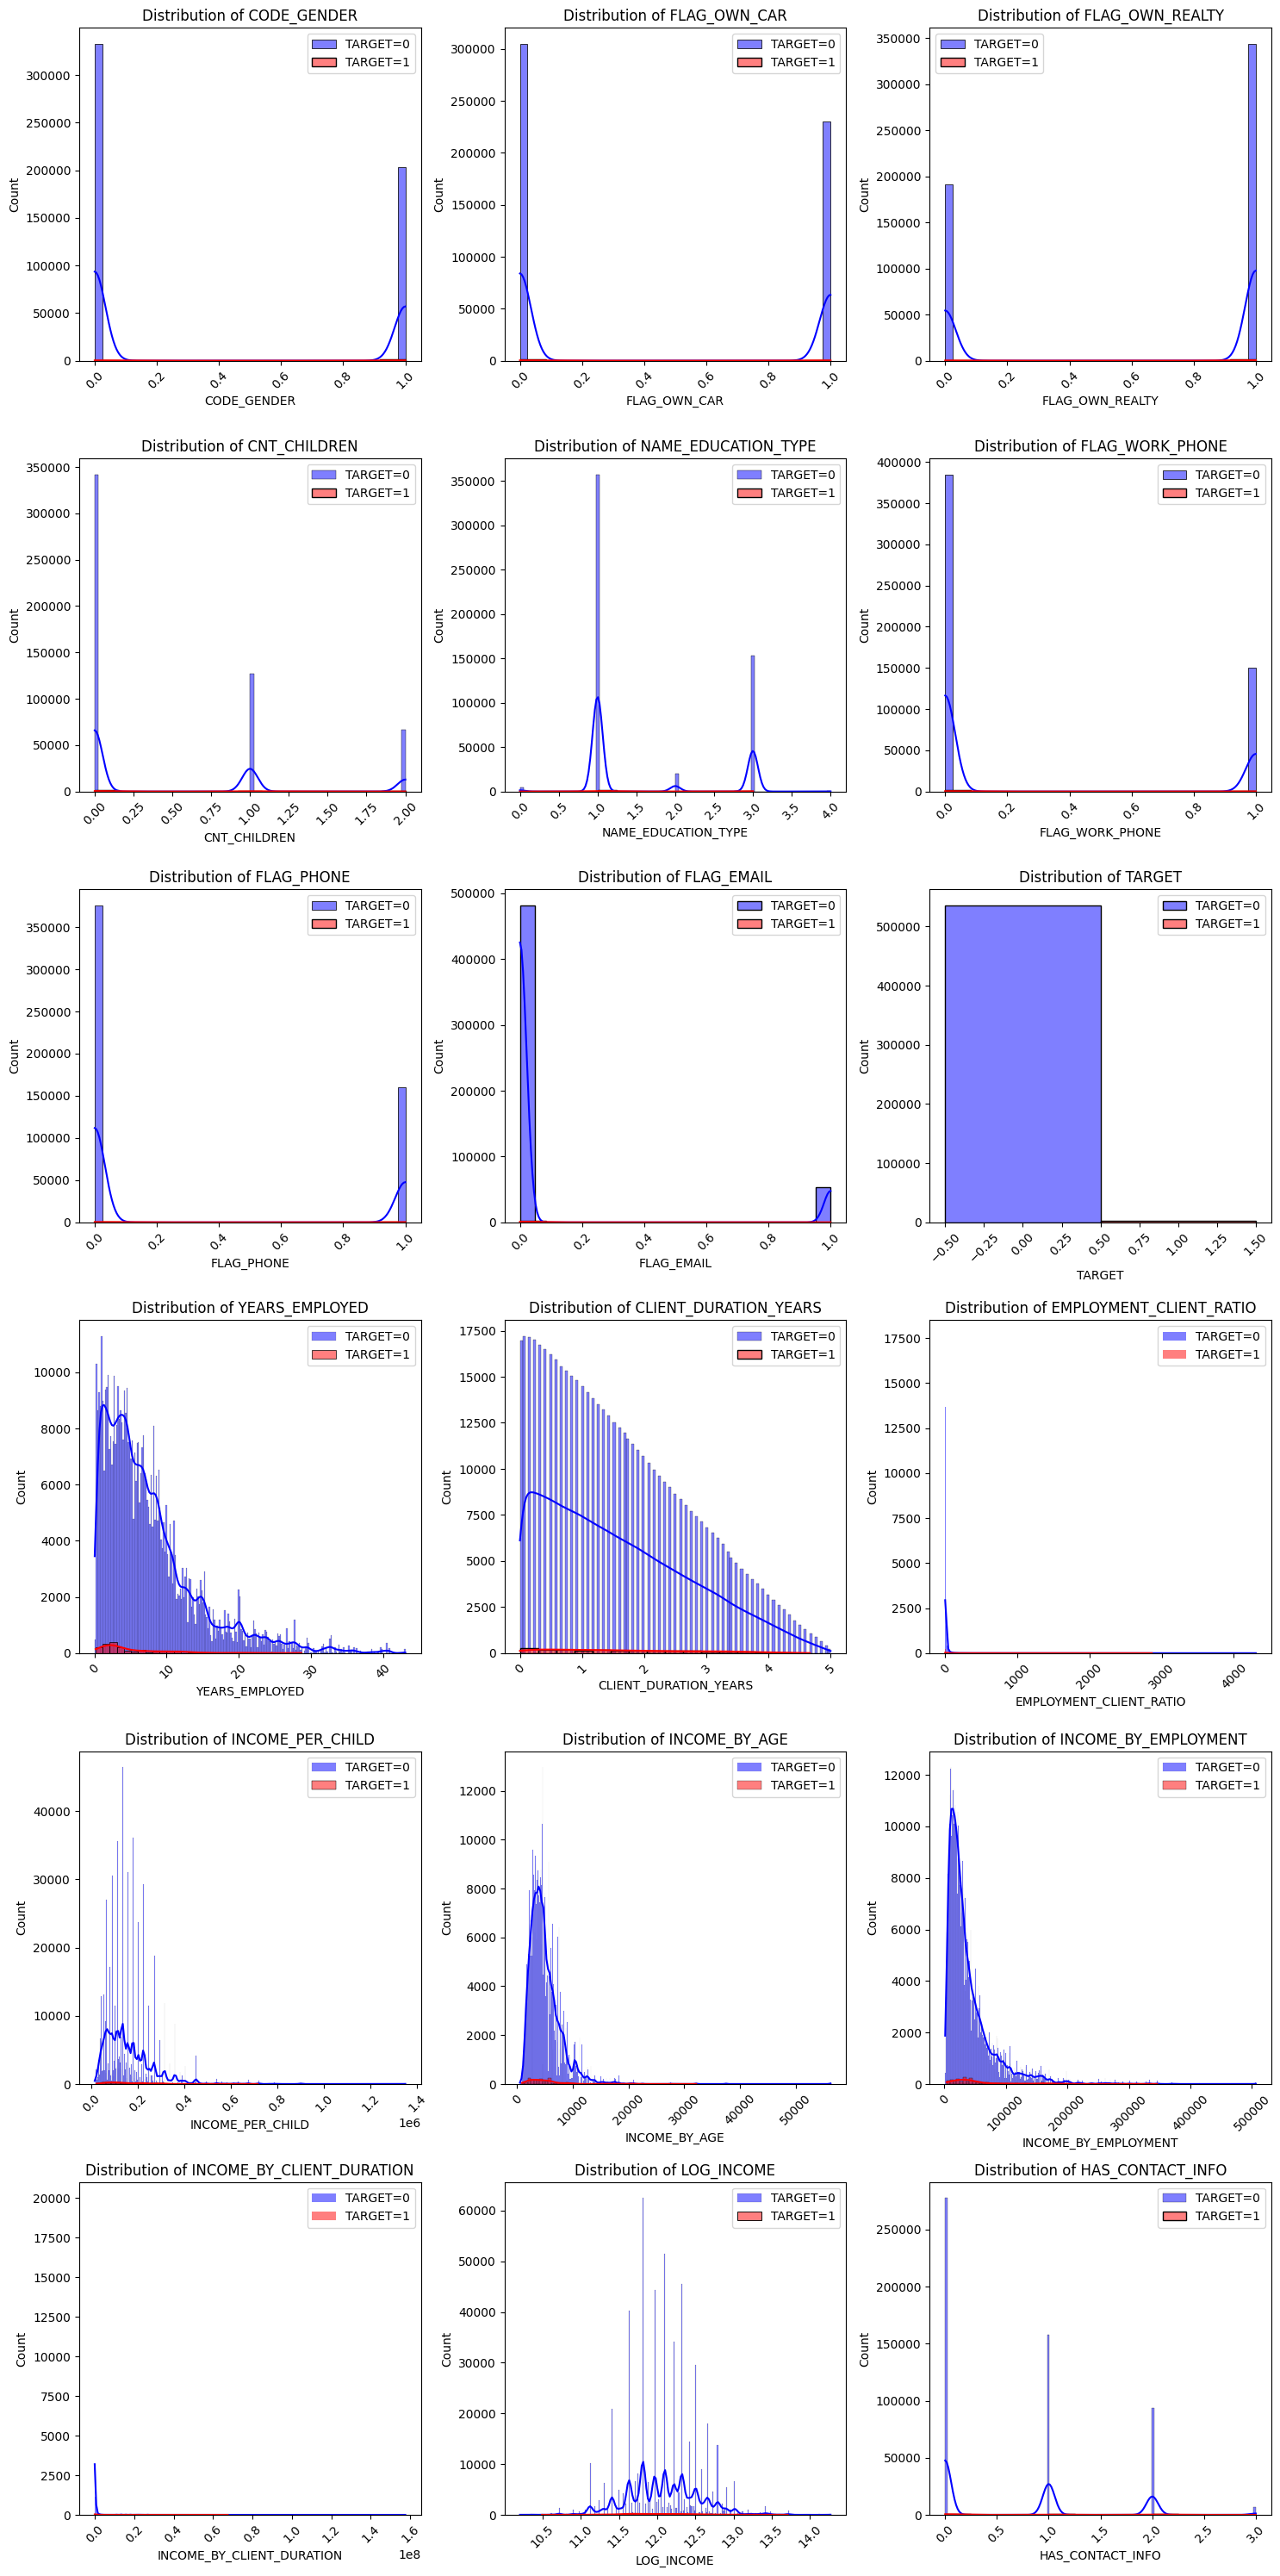

In [14]:
columns_to_plot = dataset.select_dtypes(include=['int64', 'float64']).columns
p.plot_distributions_by_target(dataset, columns_to_plot)

In [15]:
# I did my EDA in an other notebook but the data was pretty clean
top_correlations = p.get_top_correlations(corr_array, n_top=15)


Top 15 correlations:
CLIENT_DURATION_YEARS -- BEGIN_MONTHS: -1.000
BEGIN_MONTHS -- CLIENT_DURATION_YEARS: -1.000
YEARS_EMPLOYED -- DAYS_EMPLOYED: -1.000
DAYS_EMPLOYED -- YEARS_EMPLOYED: -1.000
LOG_INCOME -- AMT_INCOME_TOTAL: 0.923
AMT_INCOME_TOTAL -- LOG_INCOME: 0.923
AMT_INCOME_TOTAL -- INCOME_BY_AGE: 0.891
INCOME_BY_AGE -- AMT_INCOME_TOTAL: 0.891
LOG_INCOME -- INCOME_BY_AGE: 0.822
INCOME_BY_AGE -- LOG_INCOME: 0.822
INCOME_PER_CHILD -- AMT_INCOME_TOTAL: 0.807
AMT_INCOME_TOTAL -- INCOME_PER_CHILD: 0.807
HAS_CONTACT_INFO -- FLAG_PHONE: 0.786
FLAG_PHONE -- HAS_CONTACT_INFO: 0.786
LOG_INCOME -- INCOME_PER_CHILD: 0.756


# Preprocessing pipeline

In [16]:
# Preprocessing pipelines : NOT USED
# import pipelines as my_pipes

# Split data

In [36]:
X = dataset.drop(columns=['TARGET'])
y = dataset['TARGET']

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

(537667, 47) (537667,)


In [ ]:
onehot_cols = ["NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "JOB"]
onehot = pd.get_dummies(dataset[onehot_cols], prefix=onehot_cols)

dataset = dataset.drop(columns=onehot_cols)
dataset = pd.concat([dataset, onehot], axis=1)

## Classic Random Forest

The project instructions were not entirely clear, especially regarding the input features and the meaning of TARGET. Based on the PDF, I understand that TARGET = 1 means the person was granted credit, and TARGET = 0 means they were refused.

While our main goal is to identify risky applicants (maximize recall), we choose to optimize the F1-score as it provides a good trade-off between recall and precision. This helps us reduce credit risk while limiting the rejection of eligible clients.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import f1_score
# from optuna.integration import TQDMProgressBar


def objective(trial):
    print(f"[Trial {trial.number}] Starting with params: {trial.params}")
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }
    
    # Create and train model
    rf = RandomForestClassifier(**params, random_state=10)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

# Create study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get best parameters
best_params = study.best_params
print("\nBest parameters:", best_params)
print("Best AUC score:", study.best_value)

# Train final model with best parameters
final_rf = RandomForestClassifier(**best_params, random_state=0)
final_rf.fit(X_train, y_train)

# Evaluate final model
y_pred = final_rf.predict(X_test)
y_pred_proba = final_rf.predict_proba(X_test)[:, 1]

print("\nFinal Model Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[I 2025-06-29 12:45:55,181] A new study created in memory with name: no-name-448390ac-930d-4876-a612-8064129ce641


[Trial 0] Starting with params: {}


[I 2025-06-29 12:50:21,730] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 792, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.0.


[Trial 1] Starting with params: {}


[I 2025-06-29 12:54:56,627] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 854, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


[Trial 2] Starting with params: {}


[I 2025-06-29 12:55:58,748] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 225, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


[Trial 3] Starting with params: {}


[I 2025-06-29 13:04:22,720] Trial 3 finished with value: 0.34392523364485983 and parameters: {'n_estimators': 701, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.34392523364485983.


[Trial 4] Starting with params: {}


[I 2025-06-29 13:06:20,743] Trial 4 finished with value: 0.2896281800391389 and parameters: {'n_estimators': 158, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.34392523364485983.



Best parameters: {'n_estimators': 701, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best AUC score: 0.34392523364485983

Final Model Performance:
ROC AUC: 0.9571279638667816

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107119
           1       0.76      0.22      0.35       415

    accuracy                           1.00    107534
   macro avg       0.88      0.61      0.67    107534
weighted avg       1.00      1.00      1.00    107534



I wanted to use SHAP values but it was too long for this dataset

In [ ]:
import shap

explainer = shap.TreeExplainer(final_rf)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values[1], X_test, plot_type="bar")
plt.title("Feature Importance based on SHAP Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[1], X_test)
plt.title("SHAP Values Impact on Model Output")
plt.tight_layout() 
plt.show()

feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values[1]).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features based on SHAP values:")
print(feature_importance.head(10))

plt.figure(figsize=(15, 5))
for i, feature in enumerate(feature_importance['Feature'][:3]):
    plt.subplot(1, 3, i+1)
    shap.dependence_plot(feature, shap_values[1], X_test, show=False)
    plt.title(f"Dependence plot for {feature}")
plt.tight_layout()
plt.show()


We have several methods to handle the imbalance of the data :
- Undersampling (I'm not a big fan of this method because we'll loose a lot of data)
- Oversampling with SMOTE (never tested SMOTE so we'll use it)
- Balanced Random Forest (we change the loss function to be more balanced, we'll use it to compare)

## Balanced Random Forest

In [24]:

def objective(trial):
    print(f"[Trial {trial.number}] Starting with params: {trial.params}")
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced'  # This makes it a Balanced Random Forest
    }
    
    # Create and train model
    brf = RandomForestClassifier(**params, random_state=10)
    brf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred_proba = brf.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    
    return auc_score

# Create study
study_balanced = optuna.create_study(direction='maximize')
study_balanced.optimize(objective, n_trials=5)

# Get best parameters
best_params_balanced = study_balanced.best_params
print("\nBest parameters for Balanced Random Forest:", best_params_balanced)
print("Best AUC score:", study_balanced.best_value)

# Train final balanced model with best parameters
final_brf = RandomForestClassifier(**best_params_balanced, class_weight='balanced', random_state=0)
final_brf.fit(X_train, y_train)

# Evaluate final model
y_pred_balanced = final_brf.predict(X_test)
y_pred_proba_balanced = final_brf.predict_proba(X_test)[:, 1]

print("\nBalanced Random Forest Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))

[I 2025-06-29 04:36:30,195] A new study created in memory with name: no-name-f1080139-558c-417c-ade8-05fbfc8b664d


[Trial 0] Starting with params: {}


[I 2025-06-29 04:38:26,941] Trial 0 finished with value: 0.8935063211424474 and parameters: {'n_estimators': 368, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8935063211424474.


[Trial 1] Starting with params: {}


[I 2025-06-29 04:44:06,671] Trial 1 finished with value: 0.9338517448841098 and parameters: {'n_estimators': 878, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.9338517448841098.


[Trial 2] Starting with params: {}


[I 2025-06-29 04:45:27,902] Trial 2 finished with value: 0.9353055834649383 and parameters: {'n_estimators': 206, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.9353055834649383.


[Trial 3] Starting with params: {}


[I 2025-06-29 04:46:26,617] Trial 3 finished with value: 0.8335613010954938 and parameters: {'n_estimators': 218, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9353055834649383.


[Trial 4] Starting with params: {}


[I 2025-06-29 04:51:15,304] Trial 4 finished with value: 0.9425249050234301 and parameters: {'n_estimators': 689, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 4 with value: 0.9425249050234301.



Best parameters for Balanced Random Forest: {'n_estimators': 689, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best AUC score: 0.9425249050234301

Balanced Random Forest Performance:
ROC AUC: 0.9423097518951167

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    107119
           1       0.12      0.77      0.20       415

    accuracy                           0.98    107534
   macro avg       0.56      0.87      0.60    107534
weighted avg       1.00      0.98      0.99    107534



# SMOTE

We have to be careful with the SMOTE because it can create some overfitting. We use only the X_train and y_train!

In [25]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape)
print("Resampled training set shape:", X_train_smote.shape)

print("\nClass distribution before SMOTE:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Original training set shape: (430133, 47)
Resampled training set shape: (857172, 47)

Class distribution before SMOTE:
TARGET
0    0.996403
1    0.003597
Name: proportion, dtype: float64

Class distribution after SMOTE:
TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64


In [26]:
# Create study for SMOTE Random Forest optimization
study_smote = optuna.create_study(direction='maximize')

def objective_smote(trial):
    print(f"[Trial {trial.number}] Starting with params: {trial.params}")
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    
    # Create and train model
    rf = RandomForestClassifier(**params, random_state=0)
    rf.fit(X_train_smote, y_train_smote)
    
    # Make predictions
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    return auc_score

study_smote.optimize(objective_smote, n_trials=10)

best_params_smote = study_smote.best_params
print("\nBest parameters for SMOTE Random Forest:", best_params_smote)
print("Best AUC score:", study_smote.best_value)

# Train final SMOTE model with best parameters
final_smote_rf = RandomForestClassifier(**best_params_smote, random_state=0)
final_smote_rf.fit(X_train_smote, y_train_smote)

# Evaluate final model
y_pred_smote = final_smote_rf.predict(X_test)
y_pred_proba_smote = final_smote_rf.predict_proba(X_test)[:, 1]

print("\nSMOTE Random Forest Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

[I 2025-06-29 04:56:12,105] A new study created in memory with name: no-name-87794bb0-6967-4197-b07c-eb0e6a3b4659


[Trial 0] Starting with params: {}


[I 2025-06-29 05:00:24,356] Trial 0 finished with value: 0.9071091524491902 and parameters: {'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.9071091524491902.


[Trial 1] Starting with params: {}


[I 2025-06-29 05:06:49,783] Trial 1 finished with value: 0.8565101058084595 and parameters: {'n_estimators': 362, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.9071091524491902.


[Trial 2] Starting with params: {}


[I 2025-06-29 05:11:54,646] Trial 2 finished with value: 0.881954254906462 and parameters: {'n_estimators': 222, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9071091524491902.


[Trial 3] Starting with params: {}


[I 2025-06-29 05:27:19,221] Trial 3 finished with value: 0.9440297396983447 and parameters: {'n_estimators': 425, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.9440297396983447.


[Trial 4] Starting with params: {}


[I 2025-06-29 05:45:41,046] Trial 4 finished with value: 0.914778485856907 and parameters: {'n_estimators': 684, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.9440297396983447.


[Trial 5] Starting with params: {}


[I 2025-06-29 05:53:08,541] Trial 5 finished with value: 0.9354310716479375 and parameters: {'n_estimators': 199, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9440297396983447.


[Trial 6] Starting with params: {}


[I 2025-06-29 06:02:45,283] Trial 6 finished with value: 0.9444581001401775 and parameters: {'n_estimators': 239, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9444581001401775.


[Trial 7] Starting with params: {}


[I 2025-06-29 06:07:09,751] Trial 7 finished with value: 0.9454206148617285 and parameters: {'n_estimators': 110, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9454206148617285.


[Trial 8] Starting with params: {}


[I 2025-06-29 06:31:06,999] Trial 8 finished with value: 0.9403950251476878 and parameters: {'n_estimators': 616, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.9454206148617285.


[Trial 9] Starting with params: {}


[I 2025-06-29 06:41:30,089] Trial 9 finished with value: 0.921353798955941 and parameters: {'n_estimators': 347, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 7 with value: 0.9454206148617285.



Best parameters for SMOTE Random Forest: {'n_estimators': 110, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best AUC score: 0.9454206148617285

SMOTE Random Forest Performance:
ROC AUC: 0.9454206148617285

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107119
           1       0.42      0.57      0.48       415

    accuracy                           1.00    107534
   macro avg       0.71      0.79      0.74    107534
weighted avg       1.00      1.00      1.00    107534



# Neural network

Iteration 1, loss = 0.02395542
Validation score: 0.996490
Iteration 2, loss = 0.01776100
Validation score: 0.996583
Iteration 3, loss = 0.01655143
Validation score: 0.996768
Iteration 4, loss = 0.01586105
Validation score: 0.996722
Iteration 5, loss = 0.01532032
Validation score: 0.996815
Iteration 6, loss = 0.01488962
Validation score: 0.996606
Iteration 7, loss = 0.01466946
Validation score: 0.996350
Iteration 8, loss = 0.01440879
Validation score: 0.996606
Iteration 9, loss = 0.01434291
Validation score: 0.996606
Iteration 10, loss = 0.01425744
Validation score: 0.996583
Iteration 11, loss = 0.01414805
Validation score: 0.996606
Iteration 12, loss = 0.01400772
Validation score: 0.996768
Iteration 13, loss = 0.01394086
Validation score: 0.996792
Iteration 14, loss = 0.01393981
Validation score: 0.996861
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Neural Network Performance:
ROC AUC: 0.8986676230027701

Classification Report:
         

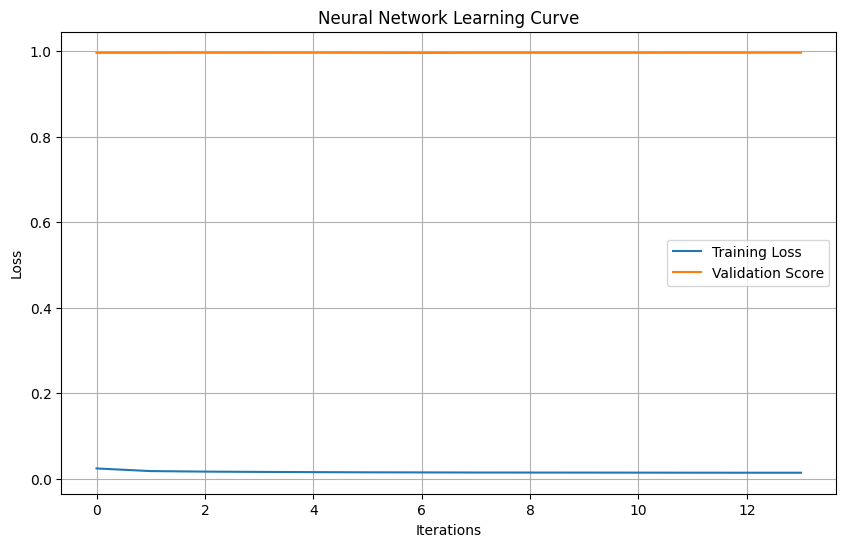

In [27]:
# Preprocessing for Neural Network using MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Very important to normalize the data for MLPClassifier because neural networks are sensitive to the scale of input features.
# Features with larger scales can dominate the learning process and we'll have a bad convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define MLP architecture
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu', 
    solver='adam',  
    max_iter=100,  # Nombre d'epochs max
    random_state=12,
    batch_size=32,
    early_stopping=True,
    n_iter_no_change=10,  # Nombre d'epochs sans amélioration avant arrêt
    validation_fraction=0.1,
    verbose=True
)

# Train the model and store the training history
mlp.fit(X_train_scaled, y_train)

# Get predictions
y_pred_mlp = mlp.predict(X_test_scaled)
y_pred_proba_mlp = mlp.predict_proba(X_test_scaled)[:, 1]

print("\nNeural Network Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_mlp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

# Voir la training curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Neural Network Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


As we can see, the MLPClassifier is undoubtedly not a good model because he predicts always the 0 class, which make sense because we didn't use SMOTE or any other method to balance the data.

Let's try something : we'll use Tensorflow because MLP is very basic and we can't use class_weight or a custom loss (we could use focal loss for example)

In [28]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define model architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)






Epoch 1/20


12098/12098 [==============================] - 22s 2ms/step - loss: 0.6560 - accuracy: 0.6428 - auc: 0.6828 - val_loss: 0.4781 - val_accuracy: 0.7717 - val_auc: 0.7655
Epoch 2/20
12098/12098 [==============================] - 20s 2ms/step - loss: 0.5566 - accuracy: 0.7237 - auc: 0.7951 - val_loss: 0.4801 - val_accuracy: 0.7861 - val_auc: 0.8126
Epoch 3/20
12098/12098 [==============================] - 20s 2ms/step - loss: 0.5122 - accuracy: 0.7683 - auc: 0.8283 - val_loss: 0.4741 - val_accuracy: 0.7776 - val_auc: 0.8305
Epoch 4/20
12098/12098 [==============================] - 20s 2ms/step - loss: 0.4869 - accuracy: 0.7846 - auc: 0.8497 - val_loss: 0.3751 - val_accuracy: 0.8788 - val_auc: 0.8679
Epoch 5/20
12098/12098 [==============================] - 20s 2ms/step - loss: 0.4686 - accuracy: 0.7934 - auc: 0.8622 - val_loss: 0.3891 - val_accuracy: 0.8410 - val_auc: 0.8704
Epoch 6/20
12098/12098 [==============================] - 20s 2ms/step - loss: 0.4595 - accuracy: 0.7

3361/3361 [==============================] - 3s 987us/step

TensorFlow Neural Network Performance:
ROC AUC: 0.883133846076152

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    107119
           1       0.02      0.79      0.04       415

    accuracy                           0.85    107534
   macro avg       0.51      0.82      0.48    107534
weighted avg       1.00      0.85      0.91    107534



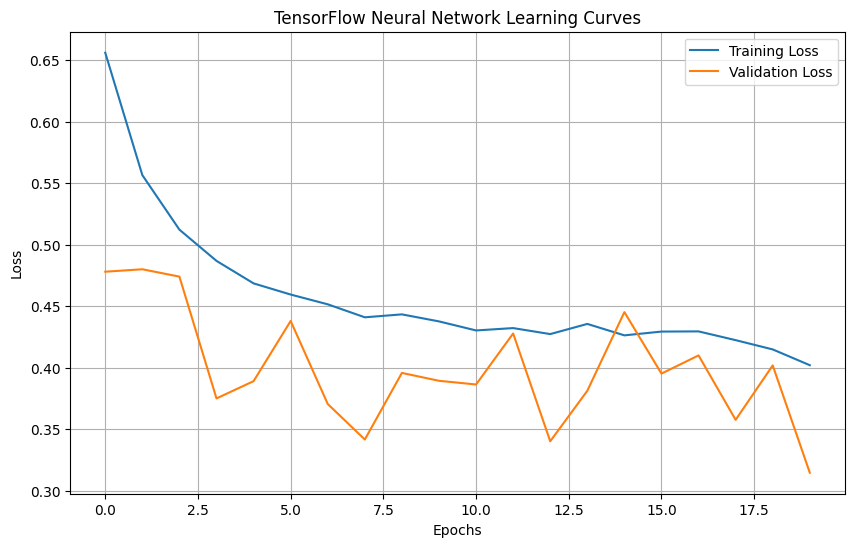

In [29]:
# Get predictions
y_pred_tf = (model.predict(X_test_scaled) > 0.5).astype(int)
y_pred_proba_tf = model.predict(X_test_scaled)

print("\nTensorFlow Neural Network Performance:")
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_tf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tf))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TensorFlow Neural Network Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

# Bonus : custom loss 

We'll use Focal Loss here :
 
This function is designed to address class imbalance during training by down-weighting easy examples and focusing more on hard ones. In reality, it's just a weighted version of the Cross Entropy Loss.

 Formula:
 FL(pt) = -αt(1-pt)ᵧ log(pt)

Where:
- pt is the model's estimated probability for the target class
- α is a weighting factor (typically α ∈ [0,1]) to balance positive/negative examples
- γ is the focusing parameter (γ ≥ 0) that modulates the rate at which easy examples are down-weighted

When γ = 0, Focal Loss is equivalent to Cross Entropy Loss
Higher γ values give more weight to hard-to-classify examples


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt


def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt + K.epsilon()))
    return loss


model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

def compile_and_train(model, X_train_scaled, y_train, X_test_scaled, y_test, gamma=2.0, alpha=0.25):
    model.compile(
        optimizer='adam',
        loss=focal_loss(gamma=gamma, alpha=alpha),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Return gamma and alpha along with history for tracking
    return {
        'history': history,
        'gamma': gamma,
        'alpha': alpha
    }

In [ ]:

# Test different combinations of gamma and alpha to compare what is the impact!
gammas = [1.0, 2.0, 3.0]
alphas = [0.25, 0.5, 0.75]

results = []

for gamma in gammas:
    for alpha in alphas:
        print(f"\nTraining with gamma={gamma}, alpha={alpha}")
        
        # Reset model weights for each combination
        model = Sequential([
            Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        
        # Train model with current gamma/alpha combination
        result = compile_and_train(
            model,
            X_train_scaled,
            y_train,
            X_test_scaled,
            y_test,
            gamma=gamma,
            alpha=alpha
        )
        
        # Get validation metrics
        val_loss = min(result['history'].history['val_loss'])
        val_accuracy = max(result['history'].history['val_accuracy'])
        val_auc = max(result['history'].history['val_auc'])
        
        results.append({
            'gamma': gamma,
            'alpha': alpha,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc
        })

# Find best combination
best_result = min(results, key=lambda x: x['val_loss'])
print("\nBest combination:")
print(f"Gamma: {best_result['gamma']}")
print(f"Alpha: {best_result['alpha']}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"Validation AUC: {best_result['val_auc']:.4f}")

# Train final model with best parameters
history = compile_and_train(
    model,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    gamma=best_result['gamma'],
    alpha=best_result['alpha']
)['history']


In [ ]:
y_pred_prob = model.predict(X_test_scaled)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

# Create a figure with subplots for different metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot validation loss for each combination
gamma_vals = [r['gamma'] for r in results]
alpha_vals = [r['alpha'] for r in results] 
val_loss_vals = [r['val_loss'] for r in results]

scatter1 = ax1.scatter(gamma_vals, alpha_vals, c=val_loss_vals, cmap='viridis')
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Alpha')
ax1.set_title('Validation Loss')
plt.colorbar(scatter1, ax=ax1)

# Plot validation accuracy
val_acc_vals = [r['val_accuracy'] for r in results]
scatter2 = ax2.scatter(gamma_vals, alpha_vals, c=val_acc_vals, cmap='viridis')
ax2.set_xlabel('Gamma')
ax2.set_ylabel('Alpha') 
ax2.set_title('Validation Accuracy')
plt.colorbar(scatter2, ax=ax2)

# Plot validation AUC
val_auc_vals = [r['val_auc'] for r in results]
scatter3 = ax3.scatter(gamma_vals, alpha_vals, c=val_auc_vals, cmap='viridis')
ax3.set_xlabel('Gamma')
ax3.set_ylabel('Alpha')
ax3.set_title('Validation AUC')
plt.colorbar(scatter3, ax=ax3)

# Plot learning curves
ax4.plot(history.history['loss'], label='Training Loss')
ax4.plot(history.history['val_loss'], label='Validation Loss')
ax4.set_title("Learning Curve (Focal Loss)")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


# Permutation Feature Importance

First of all, we'll try Permutation Feature Importance to see which features are the most important but we will just have a look at the global importance.

If we want to see the importance of each feature, we can use SHAP values, which allows us to see the local importance 